# Inference Example for ESM2nv - Logit Sampling

## Modified for logit/proba extraction
Adrian Lange, A-Alpha Bio

This notebook provides example code to extract ESM2nv logits from the language model head. Three example usages are also provided:

1. Probability heatmap for each residue, argmax, posterior probability
2. Infer probability of individual masked residues
3. In-painting multiple masked residues

---------------

SPDX-FileCopyrightText: Copyright (c) <year> NVIDIA CORPORATION & AFFILIATES. All rights reserved.
SPDX-License-Identifier: LicenseRef-NvidiaProprietary

NVIDIA CORPORATION, its affiliates and licensors retain all intellectual property and proprietary rights in and to this material, related documentation and any modifications thereto. Any use, reproduction, disclosure or distribution of this material and related documentation without an express license agreement from NVIDIA CORPORATION or its affiliates is strictly prohibited.

### Prerequisite

- Linux OS
- Pascal, Volta, Turing, or an NVIDIA Ampere architecture-based GPU.
- NVIDIA Driver
- Docker

#### Import

Components for inferencing are part of the BioNeMo ESM source code. This notebook demonstrates the use of these components.

__`ESMInferenceWrapper`__ implements __`seq_to_embedding`__ function to obtain encoder embeddings for the input protein sequence in text format. 


To run this notebook, you should launch the gRPC client in your terminal beforehand. 

The following command is an example of launching the gRPC inference client using the esm2-650M checkpoints:

```python3 -m bionemo.model.protein.esm1nv.grpc.service --model esm2nv_650M```

Note that gRPC limits request size to 4MB.


In [1]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import torch
from torch.cuda.amp import autocast
from scipy.stats import gmean

# For an optional visualization
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
import os

try:
    BIONEMO_HOME: Path = Path(os.environ['BIONEMO_HOME']).absolute()
except KeyError:
    print("Must have BIONEMO_HOME set in the environment! See docs for instructions.")
    raise

config_path = BIONEMO_HOME / "examples" / "protein" / "esm2nv" / "conf"
print(f"Using model configuration at: {config_path}")
assert config_path.is_dir()

Using model configuration at: /workspace/bionemo/examples/protein/esm2nv/conf


### Setup and Test Data

In [4]:
seqs = [
    'MSLKRKNIALIPAAGIGVRFGADKPKQYVEIGSKTVLEHVL', 
    'MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA',
]

In [5]:
from bionemo.triton.utils import load_model_config

# Load the slightly modified inference config for working with the language model head
cfg = load_model_config(config_path, config_name="infer_logits.yaml")

NOTE! Installing ujson may make loading annotations faster.


INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


In [6]:
from bionemo.triton.utils import load_model_for_inference
from bionemo.model.protein.esm1nv.infer import ESM1nvInference

inferer = load_model_for_inference(cfg, interactive=True)

print(f"Loaded a {type(inferer)}")
assert isinstance(inferer, ESM1nvInference)

[NeMo I 2024-08-23 15:48:12 utils:426] pytorch DDP is not initialized. Initializing with pytorch-lightening...


[NeMo W 2024-08-23 15:48:12 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
      rank_zero_deprecation(
    
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


[NeMo I 2024-08-23 15:48:12 utils:277] Restoring model from /workspace/bionemo/models/protein/esm2nv/esm2nv_3B_converted.nemo
[NeMo I 2024-08-23 15:48:12 utils:281] Loading model class: bionemo.model.protein.esm1nv.esm1nv_model.ESM2nvModel


[NeMo W 2024-08-23 15:48:12 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/pytorch_lightning/plugins/precision/native_amp.py:131: LightningDeprecationWarning: The `NativeMixedPrecisionPlugin` class has been renamed in v1.9.0 and will be removed in v2.0.0. Please use `pytorch_lightning.plugins.MixedPrecisionPlugin` instead.
      rank_zero_deprecation(
    
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Interactive mode selected, using strategy='auto'
[NeMo I 2024-08-23 15:48:12 exp_manager:374] Experiments will be logged at /workspace/bionemo/examples/protein/esm2nv/nemo_experiments/ESM2nv_Inference/2024-08-23_15-48-12
[NeMo I 2024-08-23 15:48:12 exp_manager:797] TensorboardLogger has been set up
[NeMo I 2024-08-23 15:48:12 utils:250] 
    
    ************** Trainer configuration ***********
[NeMo I 2024-08-23 15:48:12 utils:251] 
    name: ESM2nv_Inference
    desc: Minimum configuration for initializing a ESM2nv model for inference.
    trainer:
      precision: 16
      devices: 1
      num_nodes: 1
      accelerator: gpu
      logger: null
      accumulate_grad_batches: 1
    exp_manager:
      explicit_log_dir: null
      exp_dir: null
      name: ${name}
      create_checkpoint_callback: false
    model:
      micro_batch_size: ${model.data.batch_size}
      tensor_model_parallel_size: 1
      pipeline_model_parallel_size: 1
      seq_length: 1024
      max_position_embeddings

[NeMo W 2024-08-23 15:48:19 base:92] Using custom ESM2 Embeddings instead of the default NeMo version
[NeMo W 2024-08-23 15:48:19 attention:87] Using custom ESM2 attention instead of the default NeMo version
[NeMo W 2024-08-23 15:48:19 mlp:199] Using custom ESM2 GELU function instead of the default NeMo version
[NeMo W 2024-08-23 15:48:19 attention:87] Using custom ESM2 attention instead of the default NeMo version
[NeMo W 2024-08-23 15:48:19 mlp:199] Using custom ESM2 GELU function instead of the default NeMo version
[NeMo W 2024-08-23 15:48:19 attention:87] Using custom ESM2 attention instead of the default NeMo version
[NeMo W 2024-08-23 15:48:19 mlp:199] Using custom ESM2 GELU function instead of the default NeMo version
[NeMo W 2024-08-23 15:48:19 attention:87] Using custom ESM2 attention instead of the default NeMo version
[NeMo W 2024-08-23 15:48:19 mlp:199] Using custom ESM2 GELU function instead of the default NeMo version
[NeMo W 2024-08-23 15:48:19 attention:87] Using custom

[NeMo I 2024-08-23 15:48:28 nlp_overrides:401] Model ESM2nvModel was successfully restored from /workspace/bionemo/models/protein/esm2nv/esm2nv_3B_converted.nemo.
Loaded a <class 'bionemo.model.protein.esm1nv.infer.ESM1nvInference'>


### Turn off post_process

After loading, we switch off post processing so that the inferer still returns hidden states like we expect.

In [7]:
inferer.model.model.post_process = False

### Sequence to Hidden States

__`seq_to_hiddens`__ queries the model to fetch the encoder hiddens states for the input protein sequence. `pad_mask` is returned with `hidden_states` and contains padding information  

In [8]:
hidden_states, pad_masks = inferer.seq_to_hiddens(seqs)
print(f"{hidden_states.shape=}")
print(f"{pad_masks.shape=}")
assert tuple(hidden_states.shape) == (2, 43, 2560)  # ESM2nv has 2560 dimensions
assert tuple(pad_masks.shape) == (2, 43)

hidden_states.shape=torch.Size([2, 43, 2560])
pad_masks.shape=torch.Size([2, 43])


In [9]:
# Check pad_masks
pad_masks

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False, False]], device='cuda:0')

### Language model head

Helpers for working with the ESM2nv BERT LM head.

The tokenizer has classpath: `nemo.collections.common.tokenizers.huggingface.auto_tokenizer.AutoTokenizer`

The source code for this should be findable on the BioNeMo Docker image at:
```
/usr/local/lib/python3.10/dist-packages/nemo/collections/common/tokenizers/huggingface/auto_tokenizer.py
```

In [10]:
# Check we have the lm_head
inferer.model.model.lm_head

BertLMHead(
  (dense): Linear(in_features=2560, out_features=2560, bias=True)
  (layernorm): MixedFusedLayerNorm(torch.Size([2560]), eps=1e-05, elementwise_affine=True)
)

In [11]:
# Check vocabulary
inferer.tokenizer.vocab

['<cls>',
 '<pad>',
 '<eos>',
 '<unk>',
 'L',
 'A',
 'G',
 'V',
 'S',
 'E',
 'R',
 'T',
 'I',
 'D',
 'P',
 'K',
 'Q',
 'N',
 'F',
 'Y',
 'M',
 'H',
 'W',
 'C',
 'X',
 'B',
 'U',
 'Z',
 'O',
 '.',
 '-',
 '<null_1>',
 '<mask>']

In [12]:
def hidden_states_to_logits(hidden_states):
    """Take hidden_states from inferer.seq_to_hiddens(seqs) and apply the LM head.
    
    hidden_states.shape: <n_batch, n_max_seq_length_for_batch, 2560 hidden state dimensions>
    
    The logit shape has a fixed length of 128 tokens, however, ESM2nv only uses a vocabulary of 33.
    So, we pare down to only the relevant vocabulary classes.
    """
    with autocast(enabled=inferer.model.enable_autocast):
        lm_out = inferer.model.model.lm_head(hidden_states, inferer.model.model.word_embeddings_weight())
    logits = lm_out[:, :, :inferer.tokenizer.vocab_size]
    return logits

### Example 1a: Proba heatmap

1. Get logits for a batch of seqs
2. Pick a seq of interest
3. Drop padding mask, which includes dropping SOS and EOS tokens too
4. Apply softmax to convert logits to probabilities
5. Make a fun heatmp viz

In [13]:
batch_logits = hidden_states_to_logits(hidden_states)

i_seq_of_interest = 1
logits = batch_logits[i_seq_of_interest]
logits = logits[pad_masks[i_seq_of_interest]]

logits.shape

torch.Size([39, 33])

Text(0.5, 0, 'Position')

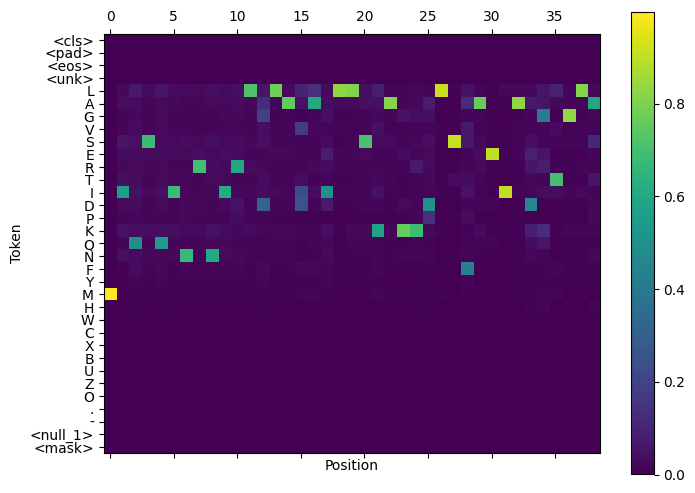

In [14]:
probas = torch.softmax(logits, dim=-1).detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(8, 6))
ms = ax.matshow(probas.T, cmap="viridis")
ax.set_yticks(range(len(inferer.tokenizer.vocab)))
ax.set_yticklabels(inferer.tokenizer.vocab)
fig.colorbar(ms)
plt.ylabel("Token")
plt.xlabel("Position")

### Example 1b: Argmax

1. Translate the logits/probas back into sequence space via argmax

In [15]:
# Argmax and compare prediction/reconstruction to true/input
pred_idx_list = np.argmax(probas, axis=-1).tolist()
true_idx_list = inferer.tokenizer.text_to_ids(seqs[i_seq_of_interest])

pred_seq = inferer.tokenizer.ids_to_text(pred_idx_list).replace(" ", "")
true_seq = inferer.tokenizer.ids_to_text(true_idx_list).replace(" ", "")

display(pred_seq)
display(
    "".join(
        [" " if a == b else "|" for a, b in zip(pred_seq, true_seq)]
    )
)
display(true_seq)

'MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA'

'                                       '

'MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA'

I guess it does pretty perfect for Nvidia's little peptide examples! Easy when there's no masking.

### Example 1c: Compute log-proba of the sequence

Given the reconstruction may not always be perfect, but we do know the exact input, we pluck out the posterior probas of the input tokens.

1. Extract the input probas
2. Log transform
3. Sum

In [16]:
rows = np.arange(len(true_idx_list))
cols = np.asarray(true_idx_list)

In [17]:
# Log posterior probability
seq_log_proba = np.log(probas[rows, cols]).sum()
seq_log_proba

-16.872187

In [18]:
# Arithmetic mean probability
np.mean(probas[rows, cols])

0.6736497

In [19]:
# Geometric mean probability
gmean(probas[rows, cols])

0.64880687

### Example 2: Mask some individual positions

1. Make some masks
2. Run the whole shebang to get probas of the masked token(s)

In [20]:
MASK_TOKEN = "<mask>"

seqs = [
    "MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA",  # original unmasked sequence
    "MIQ" + MASK_TOKEN + "QINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA",
    "MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGT" + MASK_TOKEN + "LA"
]

hidden_states, pad_masks = inferer.seq_to_hiddens(seqs)
batch_logits = hidden_states_to_logits(hidden_states)

In [21]:
i_seq_of_interest = 1
logits = batch_logits[i_seq_of_interest]
logits = logits[pad_masks[i_seq_of_interest]]

probas = torch.softmax(logits, dim=-1).detach().cpu().numpy()
probas[3]  # position of mask

array([1.9166275e-07, 1.5486411e-09, 3.4502878e-07, 1.5426036e-09,
       7.3410109e-02, 4.6226468e-02, 3.6018379e-02, 3.9589096e-02,
       6.5328188e-02, 8.7341182e-02, 6.3079573e-02, 5.6578685e-02,
       6.7858428e-02, 4.7990602e-02, 4.4281568e-02, 1.2072847e-01,
       5.4917075e-02, 7.1816191e-02, 3.7468623e-02, 3.0051233e-02,
       1.9892376e-02, 2.3158453e-02, 7.0716641e-03, 7.1327849e-03,
       5.9859522e-05, 1.7830074e-07, 5.7323231e-08, 1.3913223e-07,
       1.0480195e-08, 9.9807584e-09, 9.5423260e-09, 9.2668211e-09,
       1.5486411e-09], dtype=float32)

In [22]:
tmp_sort = sorted(enumerate(probas[3]), key=lambda x: x[1], reverse=True)
tmp = [(inferer.tokenizer.vocab[i], i, p) for i, p in tmp_sort]
tmp

[('K', 15, 0.12072847),
 ('E', 9, 0.08734118),
 ('L', 4, 0.07341011),
 ('N', 17, 0.07181619),
 ('I', 12, 0.06785843),
 ('S', 8, 0.06532819),
 ('R', 10, 0.06307957),
 ('T', 11, 0.056578685),
 ('Q', 16, 0.054917075),
 ('D', 13, 0.0479906),
 ('A', 5, 0.046226468),
 ('P', 14, 0.04428157),
 ('V', 7, 0.039589096),
 ('F', 18, 0.037468623),
 ('G', 6, 0.03601838),
 ('Y', 19, 0.030051233),
 ('H', 21, 0.023158453),
 ('M', 20, 0.019892376),
 ('C', 23, 0.007132785),
 ('W', 22, 0.007071664),
 ('X', 24, 5.985952e-05),
 ('<eos>', 2, 3.4502878e-07),
 ('<cls>', 0, 1.9166275e-07),
 ('B', 25, 1.7830074e-07),
 ('Z', 27, 1.3913223e-07),
 ('U', 26, 5.732323e-08),
 ('O', 28, 1.0480195e-08),
 ('.', 29, 9.980758e-09),
 ('-', 30, 9.542326e-09),
 ('<null_1>', 31, 9.266821e-09),
 ('<pad>', 1, 1.5486411e-09),
 ('<mask>', 32, 1.5486411e-09),
 ('<unk>', 3, 1.5426036e-09)]

Hmm, ranks the original amino acid (S) at 6-th most probable.

In [23]:
i_seq_of_interest = 2
logits = batch_logits[i_seq_of_interest]
logits = logits[pad_masks[i_seq_of_interest]]

probas = torch.softmax(logits, dim=-1).detach().cpu().numpy()
probas[-3]  # position of mask

array([2.0837189e-07, 1.6318511e-09, 6.6870302e-07, 1.6640366e-09,
       5.7541151e-02, 5.4016158e-02, 2.8374764e-01, 3.8689706e-02,
       5.4144058e-02, 4.3888409e-02, 5.2961290e-02, 3.1744529e-02,
       4.1950762e-02, 4.8703197e-02, 2.4969662e-02, 6.0563575e-02,
       2.7469456e-02, 6.0747180e-02, 3.2279260e-02, 2.5098775e-02,
       1.2670239e-02, 2.8788622e-02, 6.4930846e-03, 1.3152466e-02,
       3.7891296e-04, 4.4371561e-07, 2.6237984e-07, 2.0275142e-07,
       1.4976942e-08, 8.8389509e-09, 1.0850882e-08, 1.1261116e-08,
       1.6705494e-09], dtype=float32)

In [24]:
tmp_sort = sorted(enumerate(probas[-3]), key=lambda x: x[1], reverse=True)
tmp = [(inferer.tokenizer.vocab[i], i, p) for i, p in tmp_sort]
tmp

[('G', 6, 0.28374764),
 ('N', 17, 0.06074718),
 ('K', 15, 0.060563575),
 ('L', 4, 0.05754115),
 ('S', 8, 0.05414406),
 ('A', 5, 0.054016158),
 ('R', 10, 0.05296129),
 ('D', 13, 0.048703197),
 ('E', 9, 0.04388841),
 ('I', 12, 0.041950762),
 ('V', 7, 0.038689706),
 ('F', 18, 0.03227926),
 ('T', 11, 0.03174453),
 ('H', 21, 0.028788622),
 ('Q', 16, 0.027469456),
 ('Y', 19, 0.025098775),
 ('P', 14, 0.024969662),
 ('C', 23, 0.013152466),
 ('M', 20, 0.012670239),
 ('W', 22, 0.0064930846),
 ('X', 24, 0.00037891296),
 ('<eos>', 2, 6.68703e-07),
 ('B', 25, 4.437156e-07),
 ('U', 26, 2.6237984e-07),
 ('<cls>', 0, 2.0837189e-07),
 ('Z', 27, 2.0275142e-07),
 ('O', 28, 1.4976942e-08),
 ('<null_1>', 31, 1.1261116e-08),
 ('-', 30, 1.0850882e-08),
 ('.', 29, 8.838951e-09),
 ('<mask>', 32, 1.6705494e-09),
 ('<unk>', 3, 1.6640366e-09),
 ('<pad>', 1, 1.6318511e-09)]

Seems to like the original amino acid (G) here as most probable.

### Ignoring non-canonical amino acid tokens

Often we only want our model to predict real amino acids, not the special tokens or unknowns. To do so, we can effectively mask tokens by adding negative infinity to the logits, forcing the softmax to yield zero probability for ignored tokens.

In [25]:
IDX_TO_TOKEN = inferer.tokenizer.vocab
TOKEN_TO_IDX = {t: i for i, t in enumerate(IDX_TO_TOKEN)}

In [26]:
mask_ignore = torch.zeros(len(IDX_TO_TOKEN), dtype=torch.float32)

tokens_to_ignore = [
   "<cls>", "<eos>", "<null_1>", "<mask>", "<unk>", "<pad>", "-", ".", "X", "B", "U", "Z", "O"
]

for t in tokens_to_ignore:
    mask_ignore[TOKEN_TO_IDX[t]] = -torch.inf
    
mask_ignore

tensor([-inf, -inf, -inf, -inf, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])

In [27]:
i_seq_of_interest = 2
logits = batch_logits[i_seq_of_interest]
logits = logits[pad_masks[i_seq_of_interest]].detach().cpu()

# Add the ignore mask
probas = torch.softmax(logits + mask_ignore, dim=-1).detach().cpu().numpy()
probas[-3]  # position of mask

array([0.        , 0.        , 0.        , 0.        , 0.05756307,
       0.05403673, 0.2838557 , 0.03870444, 0.05416469, 0.04390512,
       0.05298146, 0.03175662, 0.04196674, 0.04872175, 0.02497917,
       0.06058664, 0.02747992, 0.06077031, 0.03229155, 0.02510833,
       0.01267506, 0.02879959, 0.00649556, 0.01315747, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [28]:
tmp_sort = sorted(enumerate(probas[-3]), key=lambda x: x[1], reverse=True)
tmp = [(inferer.tokenizer.vocab[i], i, p) for i, p in tmp_sort]
tmp

[('G', 6, 0.2838557),
 ('N', 17, 0.06077031),
 ('K', 15, 0.06058664),
 ('L', 4, 0.057563066),
 ('S', 8, 0.054164685),
 ('A', 5, 0.05403673),
 ('R', 10, 0.05298146),
 ('D', 13, 0.04872175),
 ('E', 9, 0.04390512),
 ('I', 12, 0.04196674),
 ('V', 7, 0.038704436),
 ('F', 18, 0.032291554),
 ('T', 11, 0.031756617),
 ('H', 21, 0.028799586),
 ('Q', 16, 0.027479919),
 ('Y', 19, 0.025108332),
 ('P', 14, 0.02497917),
 ('C', 23, 0.013157475),
 ('M', 20, 0.012675064),
 ('W', 22, 0.0064955573),
 ('<cls>', 0, 0.0),
 ('<pad>', 1, 0.0),
 ('<eos>', 2, 0.0),
 ('<unk>', 3, 0.0),
 ('X', 24, 0.0),
 ('B', 25, 0.0),
 ('U', 26, 0.0),
 ('Z', 27, 0.0),
 ('O', 28, 0.0),
 ('.', 29, 0.0),
 ('-', 30, 0.0),
 ('<null_1>', 31, 0.0),
 ('<mask>', 32, 0.0)]

The tokens we wanted to ignore all have exactly zero probability!

### Temperature

Sometimes we want to increase or decrease the randomness of our probabilities for sampling. This can be done easily by dividing logits by a "temperature" scalar prior to applying the softmax function. As temperature increases, the probabilities approach uniform, equally probable. As the temperature decreases, the probabilities approach argmax.

In [29]:
# Reduce the temperature as compare to above
temperature = 0.5

i_seq_of_interest = 2
logits = batch_logits[i_seq_of_interest]
logits = logits[pad_masks[i_seq_of_interest]].detach().cpu()
logits /= temperature

# Add the ignore mask
probas = torch.softmax(logits + mask_ignore, dim=-1).detach().cpu().numpy()

tmp_sort = sorted(enumerate(probas[-3]), key=lambda x: x[1], reverse=True)
tmp = [(inferer.tokenizer.vocab[i], i, p) for i, p in tmp_sort]
tmp

[('G', 6, 0.7146954),
 ('N', 17, 0.03275734),
 ('K', 15, 0.03255963),
 ('L', 4, 0.029390948),
 ('S', 8, 0.026023047),
 ('A', 5, 0.025900245),
 ('R', 10, 0.02489852),
 ('D', 13, 0.021055784),
 ('E', 9, 0.017098425),
 ('I', 12, 0.015621983),
 ('V', 7, 0.0132876225),
 ('F', 18, 0.009249189),
 ('T', 11, 0.008945287),
 ('H', 21, 0.007356957),
 ('Q', 16, 0.0066981767),
 ('Y', 19, 0.0055919266),
 ('P', 14, 0.0055345427),
 ('C', 23, 0.0015355743),
 ('M', 20, 0.0014250366),
 ('W', 22, 0.00037424723),
 ('<cls>', 0, 0.0),
 ('<pad>', 1, 0.0),
 ('<eos>', 2, 0.0),
 ('<unk>', 3, 0.0),
 ('X', 24, 0.0),
 ('B', 25, 0.0),
 ('U', 26, 0.0),
 ('Z', 27, 0.0),
 ('O', 28, 0.0),
 ('.', 29, 0.0),
 ('-', 30, 0.0),
 ('<null_1>', 31, 0.0),
 ('<mask>', 32, 0.0)]

In [30]:
# Increase the temperature as compare to above
temperature = 2.0

i_seq_of_interest = 2
logits = batch_logits[i_seq_of_interest]
logits = logits[pad_masks[i_seq_of_interest]].detach().cpu()
logits /= temperature

# Add the ignore mask
probas = torch.softmax(logits + mask_ignore, dim=-1).detach().cpu().numpy()

tmp_sort = sorted(enumerate(probas[-3]), key=lambda x: x[1], reverse=True)
tmp = [(inferer.tokenizer.vocab[i], i, p) for i, p in tmp_sort]
tmp

[('G', 6, 0.12961921),
 ('N', 17, 0.05997445),
 ('K', 15, 0.05988375),
 ('L', 4, 0.058370378),
 ('S', 8, 0.05662115),
 ('A', 5, 0.05655423),
 ('R', 10, 0.05599929),
 ('D', 13, 0.053700954),
 ('E', 9, 0.050977454),
 ('I', 12, 0.04983944),
 ('V', 7, 0.047863115),
 ('F', 18, 0.04371848),
 ('T', 11, 0.04335485),
 ('H', 21, 0.041287035),
 ('Q', 16, 0.040330008),
 ('Y', 19, 0.03855045),
 ('P', 14, 0.038451172),
 ('C', 23, 0.027906595),
 ('M', 20, 0.027390225),
 ('W', 22, 0.019607795),
 ('<cls>', 0, 0.0),
 ('<pad>', 1, 0.0),
 ('<eos>', 2, 0.0),
 ('<unk>', 3, 0.0),
 ('X', 24, 0.0),
 ('B', 25, 0.0),
 ('U', 26, 0.0),
 ('Z', 27, 0.0),
 ('O', 28, 0.0),
 ('.', 29, 0.0),
 ('-', 30, 0.0),
 ('<null_1>', 31, 0.0),
 ('<mask>', 32, 0.0)]

### Example 3: In-paint a bunch of masked tokens all in one go

1. Mask a short contiguous part of a seq
2. Unmask/in-paint all at once by taking the argmax
3. Unmask/in-paint by sampling probabilities

In [31]:
MASK_TOKEN = "<mask>"

before = "M"
n_contig = 8
contig = "".join([MASK_TOKEN] * n_contig)
after = "IRLDLADAILLSKAKKDLSFAEIADGTGLA"

seqs = [
    "MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA",  # original unmasked sequence
    before + contig + after
]

hidden_states, pad_masks = inferer.seq_to_hiddens(seqs)
batch_logits = hidden_states_to_logits(hidden_states)

In [32]:
# Use temperature and ignore mask
temperature = 2.0

i_seq_of_interest = 1
logits = batch_logits[i_seq_of_interest]
logits = logits[pad_masks[i_seq_of_interest]]
logits /= temperature

probas = torch.softmax(logits.cpu() + mask_ignore, dim=-1).detach().cpu().numpy()

In [33]:
# argmax in-paint: only taken over the masked contig

pred_idx_list = np.argmax(probas[len(before):len(before) + n_contig, :], axis=-1).tolist()
in_paint = inferer.tokenizer.ids_to_text(pred_idx_list).replace(" ", "")
pred_seq = before + in_paint + after

orig_seq = seqs[0]

display(pred_seq)
display(
    "".join(
        [" " if a == b else "|" for a, b in zip(pred_seq, orig_seq)]
    )
)
display(orig_seq)

'MAKLLLLEAIRLDLADAILLSKAKKDLSFAEIADGTGLA'

' ||||||||                              '

'MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA'

In [34]:
foo = []
for p in probas[len(before):len(before) + n_contig, :]:
    i = np.random.choice(np.arange(len(p)), p=p)
    foo.append(i)

In [35]:
# probability sample in-paint: only taken over the masked contig

np.random.seed(88888)

pred_idx_list = []
for p in probas[len(before):len(before) + n_contig, :]:
    i = np.random.choice(np.arange(len(p)), p=p)
    pred_idx_list.append(i)

in_paint = inferer.tokenizer.ids_to_text(pred_idx_list).replace(" ", "")
pred_seq = before + in_paint + after

orig_seq = seqs[0]

display(pred_seq)
display(
    "".join(
        [" " if a == b else "|" for a, b in zip(pred_seq, orig_seq)]
    )
)
display(orig_seq)

'MKKEAYDRTIRLDLADAILLSKAKKDLSFAEIADGTGLA'

' |||||| |                              '

'MIQSQINRNIRLDLADAILLSKAKKDLSFAEIADGTGLA'